In [45]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as signal 
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import pandas as pd
from scipy.signal import welch
from sklearn.decomposition import FastICA
import mne
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import ERPCovariances
from pyriemann.classification import MDM
from sklearn.metrics import confusion_matrix

In [46]:
# load and filter
# get sample data
df = pd.read_csv('./d2.csv', header=None)
#df = pd.read_csv('./datasets/bi2014b/group_01_sujet_01.csv', header=None)
X_train = df.iloc[:, 1:33].values
print(X_train.shape)
df['y'] = 0
df.loc[df.iloc[:, -3] == 1, 'y'] = 1
df.loc[df.iloc[:, -2] == 1, 'y'] = 2
y = df.y.values
print("things in y", np.unique(y, return_counts=True))
X_train = np.hstack((X_train, y[:, None]))
print(X_train.shape)

chnames = ['Fp1',
            'Fp2',
            'AFz',
            'F7',
            'F3',
            'F4',
            'F8',
            'FC5',
            'FC1',
            'FC2',
            'FC6',
            'T7',
            'C3',
            'Cz',
            'C4',
            'T8',
            'CP5',
            'CP1',
            'CP2',
            'CP6',
            'P7',
            'P3',
            'Pz',
            'P4',
            'P8',
            'PO7',
            'O1',
            'Oz',
            'O2',
            'PO8',
            'PO9',
            'PO10',
            'STI 014']

chtypes = ['eeg'] * 32 + ['stim']
print(chtypes)
print(chnames)
info = mne.create_info(ch_names=chnames, sfreq=512,
                        ch_types=chtypes)
m = mne.channels.make_standard_montage('standard_1020')

X_train = mne.io.RawArray(X_train.T, info)
X_train.set_montage(m)
X_train.filter(1, 24, fir_design='firwin')

(161120, 32)
things in y (array([0, 1, 2]), array([160724,    330,     66]))
(161120, 33)
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim']
['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO7', 'O1', 'Oz', 'O2', 'PO8', 'PO9', 'PO10', 'STI 014']
Creating RawArray with float64 data, n_channels=33, n_times=161120
    Range : 0 ... 161119 =      0.000 ...   314.686 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pas

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


<RawArray | 33 x 161120 (314.7 s), ~40.6 MB, data loaded>

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.3s.
0  Fraction of variance in EEG signal explained by first component: 55%
1  Fraction of variance in EEG signal explained by first component: 22%
2  Fraction of variance in EEG signal explained by first component: 1%
3  Fraction of variance in EEG signal explained by first component: 3%
4  Fraction of variance in EEG signal explained by first component: 8%
5  Fraction of variance in EEG signal explained by first component: 4%
6  Fraction of variance in EEG signal explained by first component: 3%
7  Fraction of variance in EEG signal explained by first component: 1%


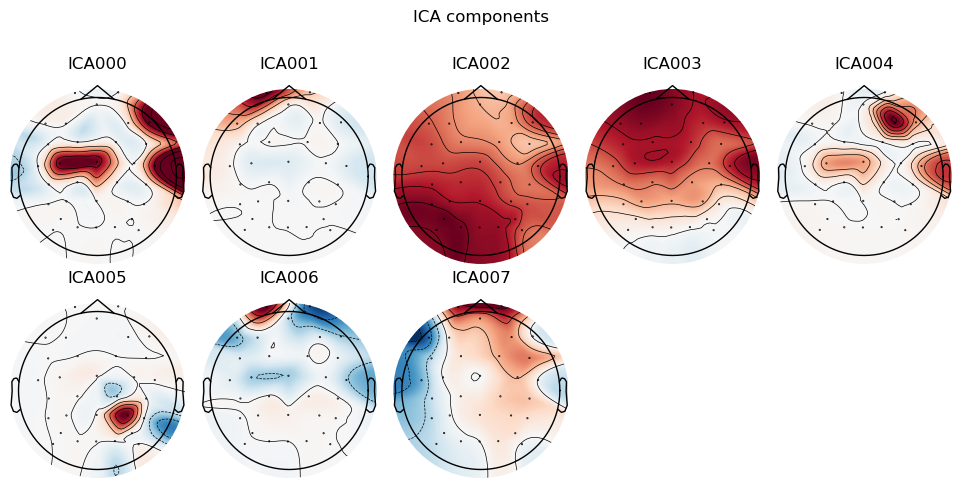

In [47]:
# ica

n_cmp = 8
ica = ICA(n_components=n_cmp, max_iter='auto', random_state=42)#, method='infomax')
ica.fit(X_train)

for i in range(n_cmp): 
    explained_var_ratio = ica.get_explained_variance_ratio(
        X_train,
        components=[i],
        ch_type='eeg'
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio['eeg'])
    print(
        f'{i}  Fraction of variance in EEG signal explained by first component: '
        f'{ratio_percent}%'
    )

ica.plot_components()
plt.show()

In [48]:
ica.exclude = [0, 1, 2]
#ica.apply(X_train)

In [49]:
# epochs
events = mne.find_events(raw=X_train, shortest_event=1, verbose=False)
event_id = {'NonTarget': 1, 'Target': 2}
tmin, tmax = 0.0, 0.8
epochs = mne.Epochs(raw=X_train, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(0, 0.1), verbose=False, preload=True)
epochs.pick_types(eeg=True)

Number of events,396
Events,NonTarget: 330Target: 66
Time range,0.000 – 0.801 sec
Baseline,0.000 – 0.100 sec


In [50]:

X = epochs.get_data()
#X = X.reshape(X.shape[0], -1)
#X = np.sum(X, axis=1)

# resample to 16 points
num_points = 16; # we will divide our window into num_points means
# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    num_chans = x.shape[1] # assumes second dim is num channels
    w = np.round((end-start)/num_points).astype(int)
    y = np.zeros((num_trials, num_chans, num_points)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = s + w
        if e > x.shape[2]:
            e = x.shape[2]
        y[:, :, i] = np.mean(x[:, :, s:e], 2)
    return y
print(wm(X, 0, X.shape[2], num_points).shape)

print(X.shape)
X = wm(X, 0, X.shape[2], num_points)

(396, 32, 16)
(396, 32, 411)


In [51]:
X = X.reshape(X.shape[0], -1)
y = epochs.events[:, -1]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
for i in range(X_train.shape[0]):
    X_train[i] = X_train[i] / np.linalg.norm(X_train[i])
clf = LinearDiscriminantAnalysis()
#clf = RandomForestClassifier(n_estimators=50, max_depth=1000, random_state=0)
print(cross_val_score(clf, X, y, cv=cv, scoring = 'roc_auc').mean())
clf.fit(X_train, y_train)

0.8975357975357976


LinearDiscriminantAnalysis()

In [52]:
y_pred = clf.predict(X_test)
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))
print("tn, fp, fn, tp", confusion_matrix(y_test, y_pred).ravel())
correct_count = 0
for gt, p in zip(y_test, y_pred):
    if gt == p:
        correct_count += 1
print("accuracy for training: ", correct_count / len(y_test))


(array([1, 2]), array([30, 10]))
(array([1, 2]), array([20, 20]))
tn, fp, fn, tp [19 11  1  9]
accuracy for training:  0.7
